### 필요한 라이브러리 다운로드

In [5]:
!pip install -qU openai langchain langchain-upstage langchain-chroma getpass4

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Upstage API Key 입력

In [6]:
# @title set API key
import os
import getpass
import warnings

warnings.filterwarnings("ignore")

# Get the Upstage API key using getpass
if "UPSTAGE_API_KEY" not in os.environ or not os.environ["UPSTAGE_API_KEY"]:
    os.environ["UPSTAGE_API_KEY"] = getpass.getpass("Enter your Upstage API key: ")

print("API key has been set successfully.")

Enter your Upstage API key: ··········
API key has been set successfully.


# csv -> Vector
## 문단 리스트 준비

In [48]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import pandas as pd
from typing import List

# patients.csv 읽기 (환자 기본 정보)
df = pd.read_csv("patients.csv")

# csv에서 사례화
def row_to_text(row) -> str:
    text = (
        f"PATIENT_ID: {row['Id']} 환자는, "
        f"{row['BIRTHDATE']}에 태어났고, 성별은 {row['GENDER']}, 인종은 {row['RACE']}, 민족성은 {row['ETHNICITY']}입니다."
        # 나이 추가할 것
    )
    return text

texts = df.apply(row_to_text, axis=1).tolist()

# 문서 리스트 준비
patient_docs = []
for _, row in df.iterrows():
    text = row_to_text(row)
    patient_docs.append(Document(page_content=text, metadata={"patient_id": row["Id"]}))

In [53]:
import pandas as pd
from langchain.schema import Document

# conditions.csv 읽기
df = pd.read_csv("conditions.csv")

# disorder만 필터링
df = df[df["DESCRIPTION"].str.contains(r"\(disorder\)", na=False)].copy()

# ✅ (disorder) 제거
df["DESCRIPTION"] = df["DESCRIPTION"].str.replace(r"\s*\(disorder\)", "", regex=True)

# PATIENT_ID 기준으로 그룹화
grouped = df.groupby("PATIENT")

# 환자별 사례화 함수
def patient_conditions_to_text(patient_id, group_df):
    conditions_text = ""
    for _, row in group_df.iterrows():
        conditions_text += (
            f"{row['START']}부터 {row['STOP']}까지 "
            f"질병 코드 {row['CODE']}의 {row['DESCRIPTION']}을(를) 진단 받았습니다. "
        )
    text = f"PATIENT_ID: {patient_id} 환자는 다음과 같은 질병을 진단 받았습니다. {conditions_text}"
    return text

# 문서 리스트 준비
conditions_docs = []
for patient_id, group_df in grouped:
    text = patient_conditions_to_text(patient_id, group_df)
    conditions_docs.append(Document(page_content=text, metadata={"patient_id": patient_id}))

print("총 문서 수:", len(conditions_docs))
print("예시 문서:\n", conditions_docs[0].page_content)

총 문서 수: 1171
예시 문서:
 PATIENT_ID: 0057c08f-6c39-0080-da1a-7d535d5ecbac 환자는 다음과 같은 질병을 진단 받았습니다. 2012-03-22부터 nan까지 질병 코드 271737000.0의 Anemia을(를) 진단 받았습니다. 2015-11-12부터 2015-11-27까지 질병 코드 66383009.0의 Gingivitis을(를) 진단 받았습니다. 2015-11-13부터 2015-12-08까지 질병 코드 444814009.0의 Viral sinusitis을(를) 진단 받았습니다. 2018-11-01부터 2018-11-24까지 질병 코드 444814009.0의 Viral sinusitis을(를) 진단 받았습니다. 2024-01-19부터 2024-02-02까지 질병 코드 66383009.0의 Gingivitis을(를) 진단 받았습니다. 2024-02-02부터 2024-02-02까지 질병 코드 18718003.0의 Gingival disease을(를) 진단 받았습니다. 


## Chunking 작업

In [34]:
# Splitter 설정
patient_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=0,
)

# 실제 split
patient_splits = patient_text_splitter.split_documents(patient_docs)

# 결과 출력
print("Splits:", len(patient_splits))


Splits: 1182


In [55]:
# Splitter 설정
conditions_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=20, # 같은 환자의 여러 질병을 고려
)

# 실제 split
conditions_splits = conditions_text_splitter.split_documents(conditions_docs)

# 결과 출력
print("Splits:", len(conditions_splits))


Splits: 5600


## Plot 시각화

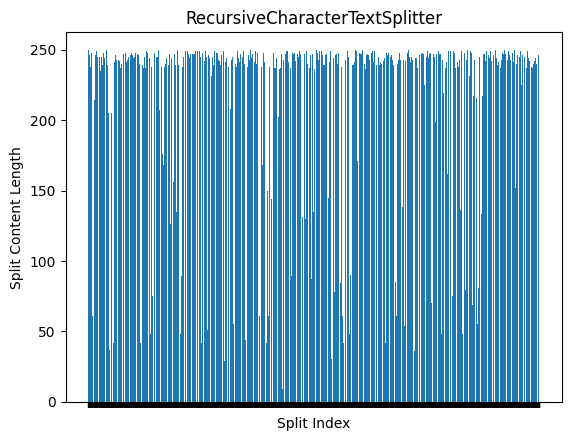

In [56]:
# 시각화
import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in conditions_splits] # 여기 splits 변경

plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Vector DB 저장

In [63]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

# 2️⃣ Chroma 벡터 DB 생성 및 문서 삽입
patient_vectorstore = Chroma.from_documents(
    documents=patient_splits,
    embedding=embeddings,
    persist_directory="./chroma_patient_db"  # ✅ 여기에 경로 추가!
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [59]:
patient_vectorstore = Chroma(
    persist_directory="./chroma_patient_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [62]:
# 2️⃣ Chroma 벡터 DB 생성 및 문서 삽입
conditions_vectorstore = Chroma.from_documents(
    documents=conditions_splits, # 43975개 -> 거의 1달러 씀, 1시간 20분 정도 소요 / 5600 -> 10분
    embedding=embeddings,
    persist_directory="./chroma_conditions_db"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [64]:
conditions_vectorstore = Chroma(
    persist_directory="./chroma_conditions_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


# LLM 생성

In [69]:
# ✅ Dense Retriever 생성
patient_retriever = patient_vectorstore.as_retriever(
    search_type='mmr',
    search_kwargs={'k': 1},
)

conditions_retriever = conditions_vectorstore.as_retriever(
    search_type='mmr',
    search_kwargs={'k': 1},
)

# ✅ 사용자의 한국어 질문 예시
query = "환자 중에 아무 사람을 골라서 해당 환자의 진단 질병을 요약해줘."

# ✅ 검색된 문서 가져오기
patient_docs = patient_retriever.invoke(query)
conditions_docs = conditions_retriever.invoke(query)

all_context = "\n".join([
    doc.page_content for doc in (patient_docs + conditions_docs)
])

# ✅ 한국어 system 프롬프트 정의
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            당신은 환자 정보에 대한 질문에 친절히 답변하는 한국어 의료 AI 어시스턴트입니다.
            아래 CONTEXT 정보를 참고하여 환자 정보를 자연스럽고 이해하기 쉽게 한국어로 풀어서 설명해 주세요.
            CONTEXT에 포함되지 않은 질병명은 절대 작성하지 마세요. 모르면 "모른다"고 답하세요.
            CONTEXT 정보는 총 2가지로 제공됩니다. 각각은 순서대로 환자 기본 정보, 진단 질병 정보입니다.
            PATIENT_ID를 기준으로 같은 환자의 정보를 연결해서 참고하세요.
            각 정보를 의료진이 환자에게 직접 설명하듯 문단 형태로 자연스럽게 이어서 작성해 주세요.
            너무 긴 리스트 형태는 피하고, 중요한 내용은 간결히 요약해 주세요.
            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# ✅ LLM chain 구성
chain = prompt | llm | StrOutputParser()

# ✅ 최종 chain 호출
response = chain.invoke({"context": all_context, "input": query})

print("\n💬 AI의 답변:")
print(response)



💬 AI의 답변:
환자 번호 c0c608f5-e65c-1d52-7b88-34ac126222a5의 환자는 1966년 7월 16일에 태어난 남성 환자분으로, 인종은 white, 민족성은 nonhispanic입니다. 이 환자분은 두 가지 질병을 진단 받으셨습니다. 첫 번째 질병은 '중이염(Otitis media)'으로, 2018년 4월 11일부터 2018년 8월 4일까지 진단을 받으셨습니다. 두 번째 질병은 '골절(Fracture of bone)'로, 2018년 6월 25일부터 2018년 8월 11일까지 진단을 받으셨습니다. 골절의 구체적인 부위는 기록되어 있지 않습니다.


In [67]:
patient_id = "59ee5bee-ed92-b2e1-c22a-5944801b159a"

# filter로 가져오기
filtered = conditions_vectorstore._collection.get(
    where={"patient_id": {"$eq": patient_id}},
    include=["documents", "metadatas"]
)

for i, doc in enumerate(filtered["documents"]):
    print(f"\n--- Document {i+1} ---")
    print(doc)
    print(filtered["metadatas"][i])


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given



--- Document 1 ---
PATIENT_ID: 59ee5bee-ed92-b2e1-c22a-5944801b159a 환자는 다음과 같은 질병을 진단 받았습니다. 2022-09-23부터 2022-10-03까지 질병 코드 444814009.0의 Viral sinusitis을(를) 진단 받았습니다.
{'patient_id': '59ee5bee-ed92-b2e1-c22a-5944801b159a'}


TMI: 여기까지 돌리는 데 Billing 0.05$ 사용
### Now What?
GPT 추천:
# ✅ 💡 선택지 크게 두 가지

## 🅰️ **전부 조인 후 넣기 (One big chunk)**

### ✔️ 장점

* 환자 한 명에 대한 정보가 하나의 청크에 모두 담김 → 질문할 때 정확한 컨텍스트 제공
* 질병, 약물, 투약 주의사항 등을 한 번에 설명하기 쉬움

### ❌ 단점

* row 폭발 (조인한 경우 레코드 수 \* 약물 수 \* 진단 수 …)
* 청크가 너무 커짐 → 나눠야 할 때 문맥이 깨짐
* 관리/업데이트 어려움

---

## 🅱️ **테이블별로 분리, Retriever에서 동적 컨텍스트 결합 (멀티-벡터 전략)**

### ✔️ 장점

* 각 테이블 정보 독립적으로 유지
* 스케일 확장 유리 (예: 약물 DB 업데이트, 질환 DB 변경 등)
* Retriever 단계에서 동적으로 "다중 소스" 컨텍스트 결합 가능

### ❌ 단점

* QA 정확도를 높이려면 "적절한 컨텍스트 조합 로직" 필요
* LLM 프롬프트 설계가 복잡

---

# ✅ 💡 현업과 연구에서 많이 쓰는 전략: **멀티-벡터 & 멀티-Retriever 방식**

### 💡 구조

```
[벡터 DB A] ← 환자 정보 테이블 (예: Patient Demographics)
[벡터 DB B] ← 질병 정보 테이블 (예: Diagnoses)
[벡터 DB C] ← 약물 정보 테이블 (예: Medications)
```

---

## ✅ 1️⃣ 각 테이블별로 개별 벡터 DB 구축

* 각 테이블 row 단위로 Document 생성 → 독립 embedding
* 예:

```python
patient_docs = [Document(page_content="환자 A: 60세, 남성, 당뇨, 고혈압", metadata={"patient_id": "A"})]
diagnosis_docs = [Document(page_content="환자 A: 진단명: 당뇨병, HbA1c: 8.5%", metadata={"patient_id": "A"})]
medication_docs = [Document(page_content="환자 A: 메트포르민 투약 중", metadata={"patient_id": "A"})]
```

---

## ✅ 2️⃣ Retriever 여러 개 선언

```python
patient_retriever = patient_vectorstore.as_retriever(search_kwargs={'k': 1})
diagnosis_retriever = diagnosis_vectorstore.as_retriever(search_kwargs={'k': 1})
medication_retriever = medication_vectorstore.as_retriever(search_kwargs={'k': 1})
```

---

## ✅ 3️⃣ 질문 시, **각 Retriever에서 병렬 검색 → 결과 컨텍스트 합침**

```python
patient_docs = patient_retriever.invoke(query)
diagnosis_docs = diagnosis_retriever.invoke(query)
medication_docs = medication_retriever.invoke(query)

all_context = "\n".join([
    doc.page_content for doc in (patient_docs + diagnosis_docs + medication_docs)
])
```

---

## ✅ 4️⃣ LLM에 합쳐진 context 전달

```python
response = chain.invoke({"context": all_context, "input": query})
```

---

# ✅ 💬 **실제 사용 시 포인트**

| 고려 사항         | 내용                                                                      |
| ------------- | ----------------------------------------------------------------------- |
| ✅ 컨텍스트 길이     | 여러 테이블 합치면 길어질 수 있음 → 필요하면 각 테이블에서 `k` 값을 줄이거나 요약 추가                    |
| ✅ metadata 활용 | `patient_id`, `diagnosis_id` 등으로 cross-link → 필터 기반 검색 강화 가능            |
| ✅ 프롬프트 설계     | "아래에 환자 기본정보, 질병정보, 약물정보가 있습니다. 이 환자에게 적합한 약물과 투약 시 주의사항을 종합적으로 알려주세요." |

---

# ✅ ✅ 💡 **요약**

### 💡 다 조인? ❌

* 데이터 폭발, 관리 불가

### 💡 테이블별 분리 & Retriever에서 조합? ✅

* 유연, scalable, 관리 쉽고, 정확도 높음

---